## First of all, lets download our data files and see whats is inside them.

In [1]:
import numpy as np # linear algebra library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) library
import os
import gc
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 2
%matplotlib inline
modules_path = os.path.abspath("modules")
if modules_path not in sys.path:
    sys.path.append(modules_path)
from helper_functions import HelperFunctions # type: ignore

pal = sns.color_palette()

print('File sizes')
for f in os.listdir('csv'):
  print(f.ljust(30) + ' ' + str(round(os.path.getsize('csv/' + f) / 1000000, 2)) + ' MB')
  
df_train = pd.read_csv('csv/quora_question_pairs_train.csv.zip')
df_train = df_train.sample(n=10000, random_state=42).reset_index(drop=True)  ## 5000 works quite good for debugging here

df_test = pd.read_csv('csv/quora_question_pairs_test.csv.zip')


File sizes
quora_question_pairs_train.csv.zip 18.41 MB
quora_question_pairs_test.csv.zip 4.6 MB


#### As we can see, train data is larger than test data.
#### Thus we can assume, that test dataset is smaller than train one.

## Let's see what columns we have in our train dataset.

In [2]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,251224,365287,365288,What is the most boring job you've ever had?,What is the most boring/interesting job you ha...,1
1,312791,19250,43524,How do you delete an instagram account when yo...,How do I delete my Instagram account when I ha...,1
2,71225,122612,122613,What is the best team for Pokemon Heart Gold?,How do you find Rock Climb Pokemon in Heart Gold?,0
3,36689,66877,66878,How is all year weather at Sydney?,Dua for love back?,0
4,6225,12204,12205,Why do Muslims ardently support secularism whe...,Why do Muslims preach secularism when they are...,1


In [3]:
df_train.shape

(10000, 6)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            10000 non-null  int64 
 1   qid1          10000 non-null  int64 
 2   qid2          10000 non-null  int64 
 3   question1     10000 non-null  object
 4   question2     10000 non-null  object
 5   is_duplicate  10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 468.9+ KB


Total number of question pairs for train: 10000
Duplicate pairs: 35.76%
Total number of questions in train data: 19400
Number of questions which appear multiple times: 541


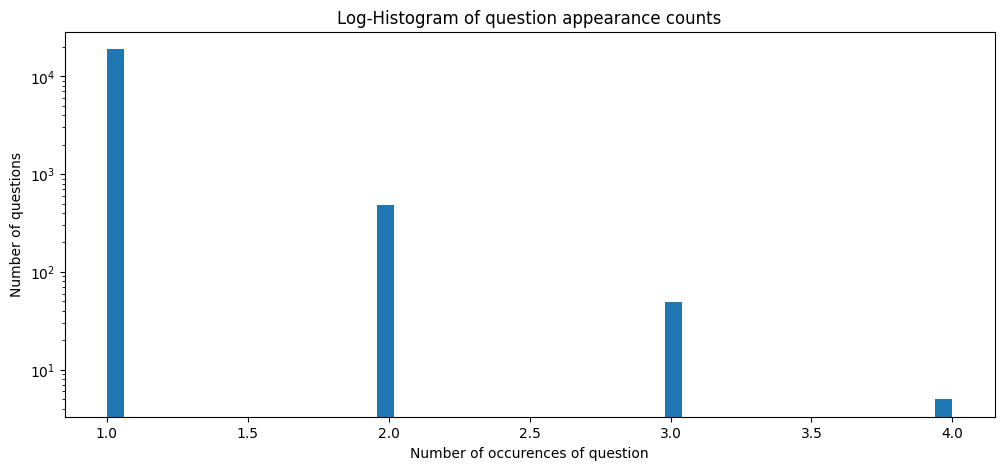

In [5]:
HelperFunctions.identify_duplicate_questions(df_train, 'train')

#### As we can see there are almost 37% of duplicate pairs in train data.
#### Most of questions appear only multiple times and very few questions appear several times (and a few questions appearing many times). There are several outliers - 100 and 120 times for one question.

## Now lets make text analysis

mean-train: 59.55 std-train: 31.41 max-train: 364 mean-test: 59.80 std-test: 31.94 max-test: 1169


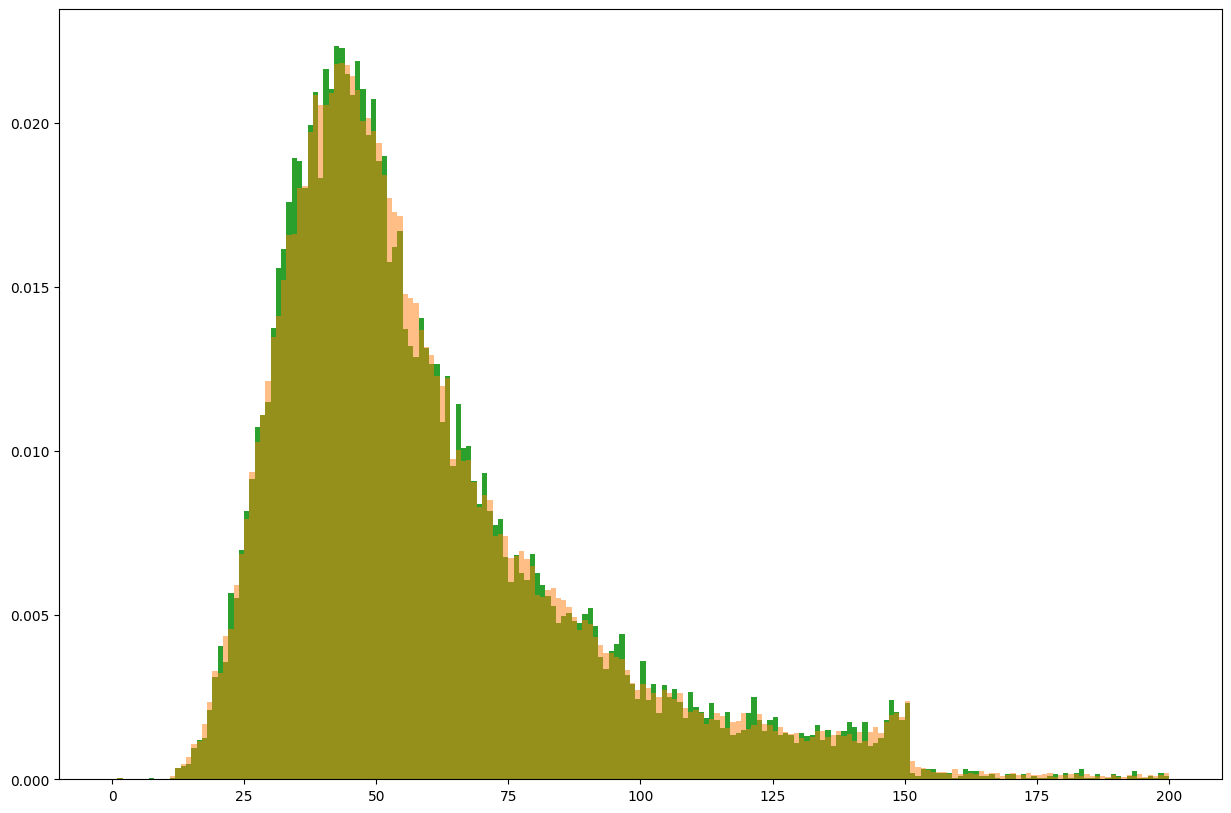

In [6]:
train_qs, test_qs = HelperFunctions.text_analysis(df_train, df_test, pal)

#### We can see that all questions are somewhere between 15 and 150 word and there is a steep cut after 150 characters.
#### Also this histogram was cut at 200 characters because questions more that 200 chars long are very rare.

 mean-train 11.01005 std-train 5.801786969038221 mean-test 11.061243167033565 std-test 5.880848807437454 max-train 77 max-test 237


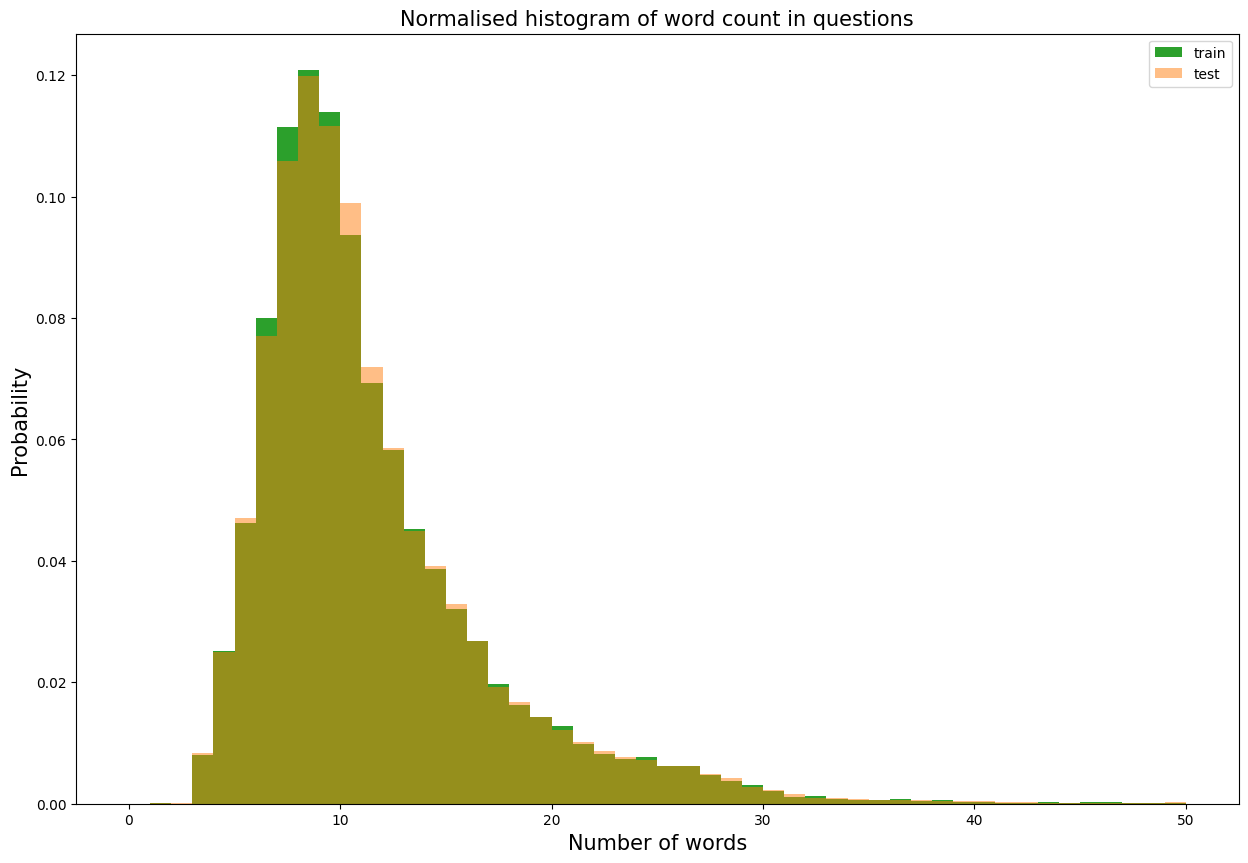

In [7]:
HelperFunctions.word_count(train_qs, test_qs, pal)

#### As for word count, the most popular number is 10.

## Now lets see what are mos popular words in our dataset.

(np.float64(-0.5), np.float64(1439.5), np.float64(1079.5), np.float64(-0.5))

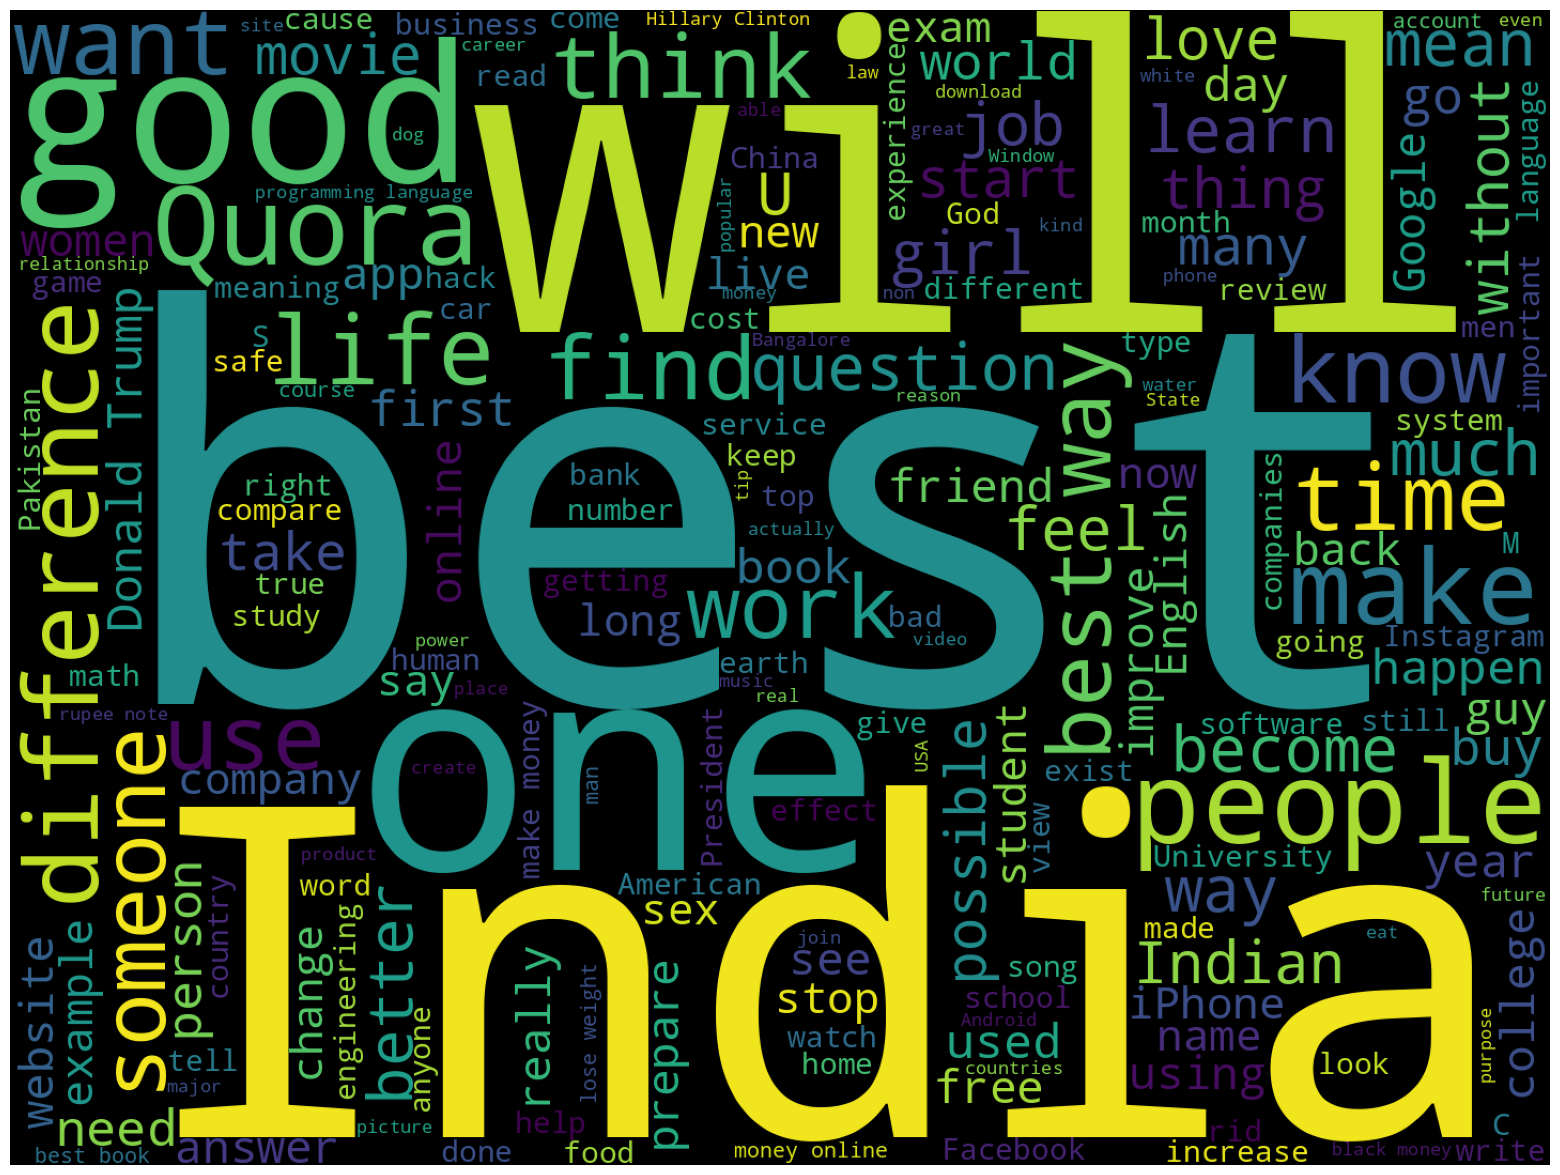

In [8]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

### Lets make semantic analysis of our dataset

#### We'll analyze punctuation in questions. This may help with feature engineering later.

In [9]:
HelperFunctions.semantic_analysis(train_qs)

Questions with question marks: 99.86%
Questions with [math] tags: 0.12%
Questions with full stops: 6.43%
Questions with capitalised first letters: 0.01%
Questions with capital letters:  99.94%
Questions with numbers: 11.61%


### Also lets make feature analysis in order to find out how powerful are some features

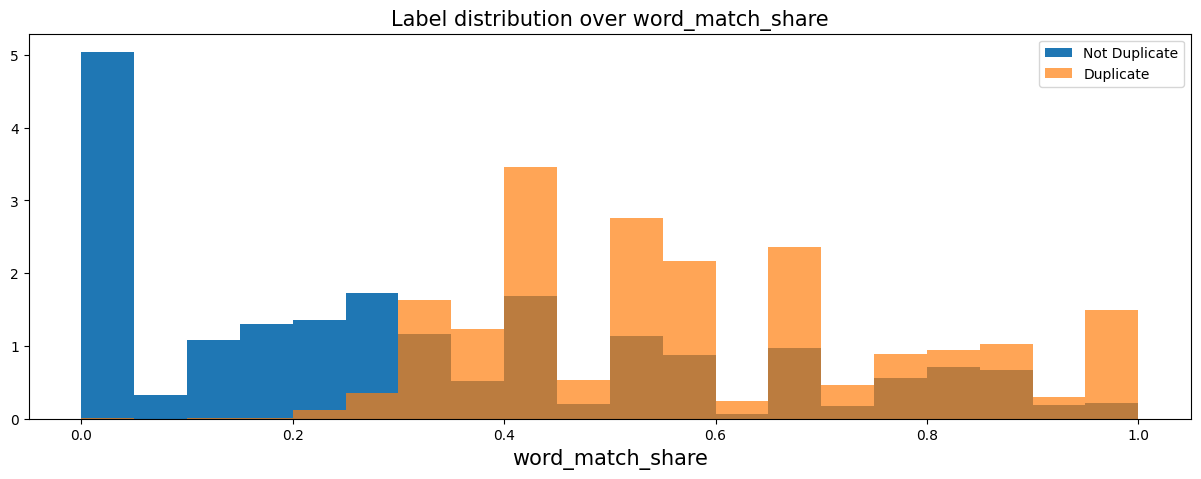

In [10]:
train_word_match = HelperFunctions.feature_analysis(df_train)

#### Here we can see that this feature `word_match_share` has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones.
#### Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

#### TF-IDF

### Now we are going to improve this feature by using TF-IDF (term-frequency-inverse-document-frequency). This means that we weight terms by how uncommon they are, meaning we are more concerned about rare words in both questions rather than common ones.This makes sense as we are more concerned about words like "exercise" rather than "and" - as the uncommon words will be more indicative of the content

In [11]:
weights = HelperFunctions.show_common_words_and_weights(train_qs)

Most common words and weights: 

[('the', 9.657170449058426e-05), ('what', 0.00011399908800729594), ('is', 0.00012981955082435416), ('how', 0.0001559332605644784), ('i', 0.00015792798483891344), ('a', 0.0001650709805216243), ('to', 0.00016515276630883568), ('in', 0.00017479461632581716), ('of', 0.00020275750202757503), ('do', 0.0002101281781886951)]

Least common words and weights: 
[('secularism', 0.000998003992015968), ('majority?', 0.000998003992015968), ('-1?', 0.000998003992015968), ('castle', 0.000998003992015968), ('yu-gi-oh?', 0.000998003992015968), ('slokas', 0.000998003992015968), ('barbados,', 0.000998003992015968), ('glue', 0.000998003992015968), ('caffeine?', 0.000998003992015968), ('disturbing', 0.000998003992015968)]


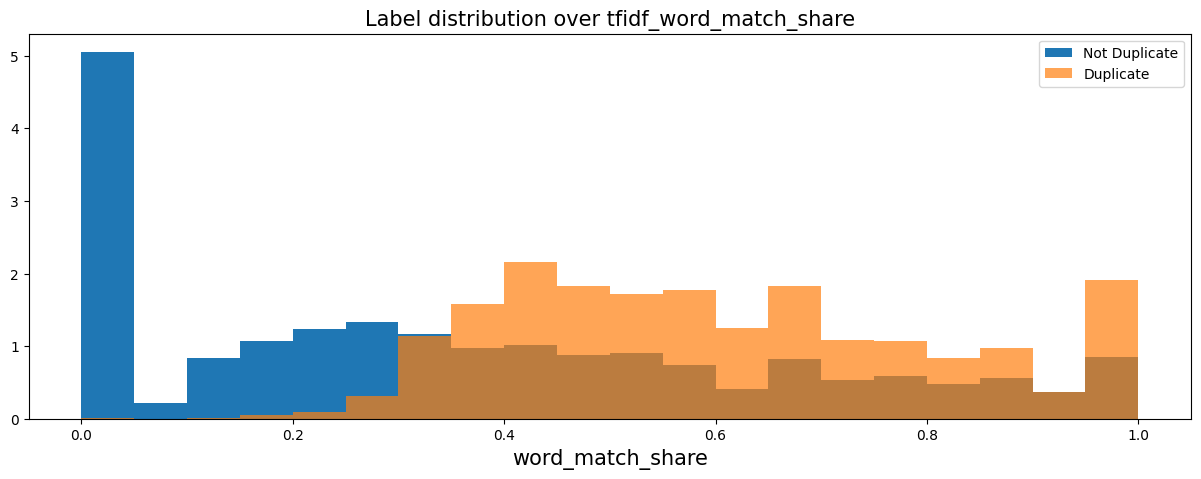

In [12]:
tfidf_train_word_match = HelperFunctions.show_tlidf_match_share(df_train, weights)

In [13]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7748785663939199
TFIDF AUC: 0.7502930060232741


Most common words and weights: 

[('the', 1.312163758037003e-05), ('what', 1.5841333206602666e-05), ('is', 1.8173227201686474e-05), ('how', 2.2360359554581637e-05), ('i', 2.299484915378955e-05), ('a', 2.333994631812347e-05), ('to', 2.4065651096190408e-05), ('in', 2.4902258634858183e-05), ('of', 3.0462728851250496e-05), ('do', 3.131752842065704e-05)]

Least common words and weights: 
[('"truth', 0.000998003992015968), ('seedless', 0.000998003992015968), ('petitions', 0.000998003992015968), ('brahmdagh', 0.000998003992015968), ('bugti', 0.000998003992015968), ('zaire', 0.000998003992015968), ('lybia?', 0.000998003992015968), ('sooryavansham', 0.000998003992015968), ('gf/bf', 0.000998003992015968), ('"behind', 0.000998003992015968)]


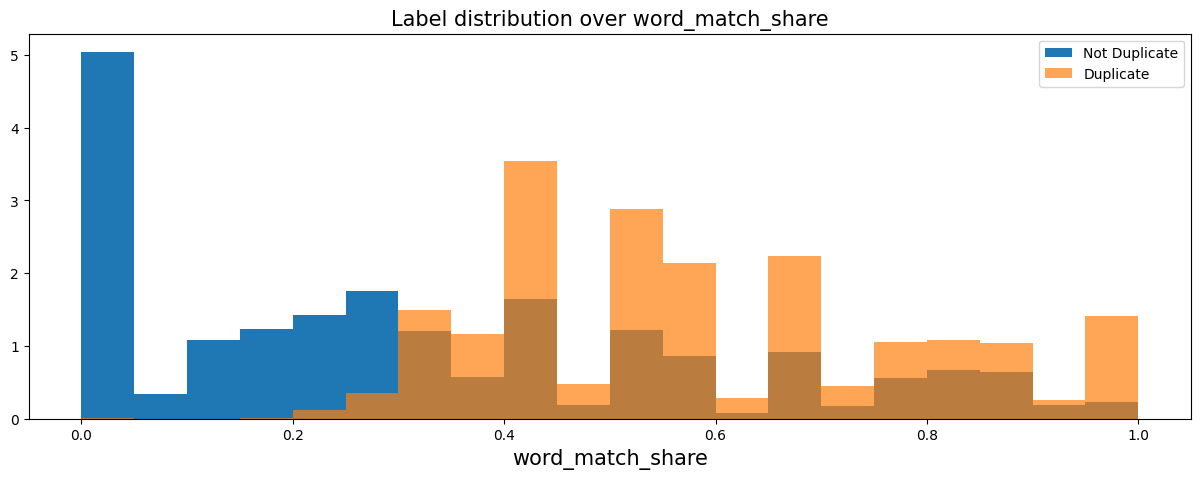

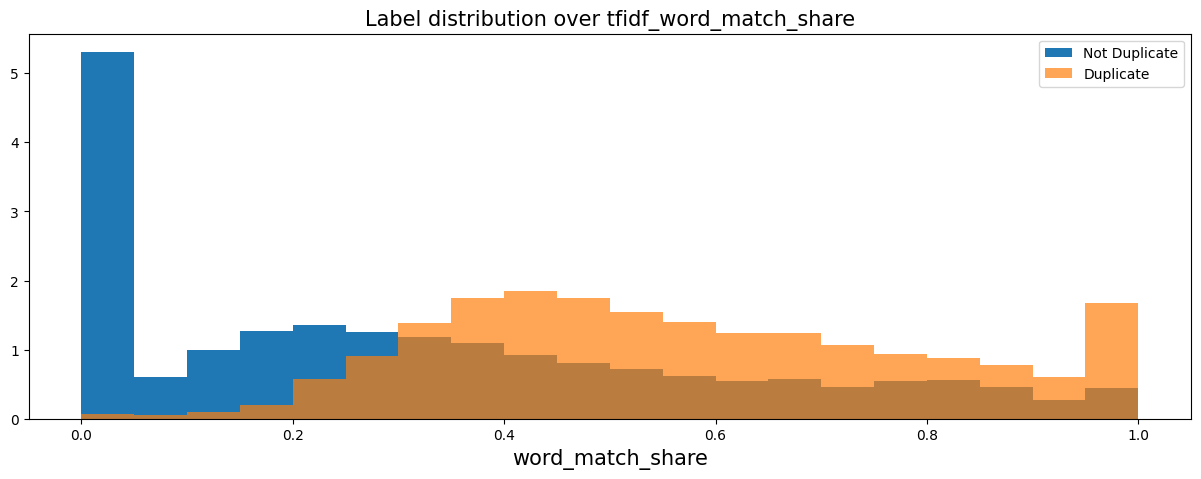

In [14]:
df_train['train_word_match'] = train_word_match
df_train['tfidf_train_word_match'] = tfidf_train_word_match

test_word_match = HelperFunctions.feature_analysis(df_test)
weights = HelperFunctions.show_common_words_and_weights(test_qs)
tfidf_test_word_match = HelperFunctions.show_tlidf_match_share(df_test, weights)

df_test['test_word_match'] = train_word_match
df_test['tfidf_test_word_match'] = tfidf_train_word_match


### So it looks like our TF-IDF actually got worse in terms of overall AUC, which is a bit disappointing. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

### However, I still think that this feature should provide some extra information which is not provided by the original feature. Our next job is to combine these features and use it to make a prediction.

In [15]:
df_train.shape

(10000, 8)

In [16]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,train_word_match,tfidf_train_word_match
0,251224,365287,365288,What is the most boring job you've ever had?,What is the most boring/interesting job you ha...,1,0.500000,0.529560
1,312791,19250,43524,How do you delete an instagram account when yo...,How do I delete my Instagram account when I ha...,1,0.666667,0.654706
2,71225,122612,122613,What is the best team for Pokemon Heart Gold?,How do you find Rock Climb Pokemon in Heart Gold?,0,0.545455,0.655121
3,36689,66877,66878,How is all year weather at Sydney?,Dua for love back?,0,0.000000,0.000000
4,6225,12204,12205,Why do Muslims ardently support secularism whe...,Why do Muslims preach secularism when they are...,1,0.470588,0.636036


#### Now lets use BERT classifier for tuning our dataset.

In [17]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

In [18]:
df = df_train.fillna('')  # replace NaNs with empty string

## Tokenize with BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare the lists of questions
q1 = list(df['question1'])
q2 = list(df['question2'])

# Tokenize as pairs
inputs = tokenizer(
    q1, q2,
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors='pt'
)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [19]:
## Extract BERT Embeddings
bert = BertModel.from_pretrained('bert-base-uncased')
bert.eval()  # disable dropout for inference

with torch.no_grad():
    outputs = bert(**inputs)
    # CLS embedding is at position 0
    cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [num_samples, 768]


In [20]:
## Prepare Extra Features
import numpy as np
df[['train_word_match', 'tfidf_train_word_match']] = (
    df[['train_word_match', 'tfidf_train_word_match']]
    .replace('', np.nan)
    .astype(float)
    .fillna(0)
)
extra_features = df[['train_word_match', 'tfidf_train_word_match']].values
extra_features = torch.tensor(extra_features, dtype=torch.float32)
extra_features = torch.tensor(extra_features, dtype=torch.float32)  # [num_samples, 2]

## Concatenate Features
# [num_samples, 770] = [num_samples, 768] + [num_samples, 2]
full_features = torch.cat([cls_embeddings, extra_features], dim=1)

## Prepare Labels and Train/Test Split
labels = torch.tensor(df['is_duplicate'].values, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(
    full_features, labels, test_size=0.2, random_state=42
)

In [21]:
## Create Dataset and DataLoader
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = FeatureDataset(X_train, y_train)
val_dataset = FeatureDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=0)

In [22]:
## Build a Simple Classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

In [23]:
model = SimpleClassifier(full_features.shape[1])

## Train the Classifier
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [24]:
# Training loop
for epoch in range(10):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} training loss: {loss.item():.4f}")


Epoch 1 training loss: 0.5118
Epoch 2 training loss: 0.4981
Epoch 3 training loss: 0.3724
Epoch 4 training loss: 0.2699
Epoch 5 training loss: 0.4905
Epoch 6 training loss: 0.4273
Epoch 7 training loss: 0.4614
Epoch 8 training loss: 0.3675
Epoch 9 training loss: 0.4270
Epoch 10 training loss: 0.4103


In [25]:
# Cross-Entropy Loss Evaluation (VALIDATION)
model.eval()
val_losses = []
all_logits = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        val_losses.append(loss.item())
        all_logits.append(logits.cpu())
        all_targets.append(y_batch.cpu())

avg_val_loss = np.mean(val_losses)
print(f'Validation Cross-Entropy Loss (BCE): {avg_val_loss:.4f}')

probs = torch.sigmoid(torch.cat(all_logits)).numpy()
targets = torch.cat(all_targets).numpy()
auc = roc_auc_score(targets, probs)
print(f'Validation ROC AUC: {auc:.4f}')

Validation Cross-Entropy Loss (BCE): 0.4211
Validation ROC AUC: 0.8704


#### Summary:
- Our model is working well.
- Loss and AUC indicate we have a good starting point for this problem.

### Lets try to use some classic models for our dataset

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit on both questions for a shared vocabulary
all_qs = pd.concat([df_train['question1'].fillna(''), df_train['question2'].fillna('')])
tfidf = TfidfVectorizer(max_features=10000)
tfidf.fit(all_qs)

# Transform each question
q1_vec = tfidf.transform(df_train['question1'].fillna(''))  # sparse matrix
q2_vec = tfidf.transform(df_train['question2'].fillna(''))

In [30]:
# Concatenate the Vectors

# Horizontally join the two vectors for each pair:
  
from scipy.sparse import hstack

X = hstack([q1_vec, q2_vec])  # shape: (n_samples, 2 * n_features)
y = df_train['is_duplicate'].values

In [46]:
# Train a Classic ML Model

# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

probs_lr = logreg.predict_proba(X_val)[:, 1]
print('Logistic Regression BCE:', log_loss(y_val, probs_lr))
print('Logistic Regression ROC AUC:', roc_auc_score(y_val, probs_lr))

Logistic Regression BCE: 0.558222862561956
Logistic Regression ROC AUC: 0.753770555557346


In [33]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
probs_rf = rf.predict_proba(X_val)[:, 1]
print('Random Forest BCE:', log_loss(y_val, probs_rf))
print('Random Forest ROC AUC:', roc_auc_score(y_val, probs_rf))

Random Forest BCE: 0.5601603127030169
Random Forest ROC AUC: 0.7612869575680226


In [ ]:
# XGBoost

import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='auto'
)
xgb_clf.fit(X_train, y_train)
probs_xgb = xgb_clf.predict_proba(X_val)[:, 1]
print('XGBoost BCE:', log_loss(y_val, probs_xgb))
print('XGBoost ROC AUC:', roc_auc_score(y_val, probs_xgb))

XGBoost BCE: 0.5715877293350138
XGBoost ROC AUC: 0.7405044524731127


In [37]:
# Using Additional Features (e.g., word match, tfidf match)

# We want to add features such as train_word_match and tfidf_train_word_match, concatenate them to X:

import numpy as np
add_feats = df_train[['train_word_match', 'tfidf_train_word_match']].fillna(0).astype(float).values
from scipy.sparse import csr_matrix

X_with_feats = hstack([X, csr_matrix(add_feats)])

In [51]:
# Now lets use X_with_feats in our models

# X_with_feats is your full feature matrix (can be sparse)
# y is your target array (0/1)
from sklearn.model_selection import train_test_split

X_train_with_feats, X_val_with_feats, y_train_with_feats, y_val_with_feats = train_test_split(X_with_feats, y, test_size=0.2, random_state=42)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import log_loss, roc_auc_score

# Logistic Regression
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_with_feats, y_train_with_feats)
probs_lr_with_feats = logreg.predict_proba(X_val_with_feats)[:, 1]
print('Logistic Regression BCE:', log_loss(y_val_with_feats, probs_lr_with_feats))
print('Logistic Regression ROC AUC:', roc_auc_score(y_val_with_feats, probs_lr_with_feats))
print('\n')

# Random Forest
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_with_feats, y_train_with_feats)
probs_rf_with_feats = rf.predict_proba(X_val_with_feats)[:, 1]
print('Random Forest BCE:', log_loss(y_val_with_feats, probs_rf_with_feats))
print('Random Forest ROC AUC:', roc_auc_score(y_val_with_feats, probs_rf_with_feats))
print('\n')

# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='auto'
)
xgb_clf.fit(X_train_with_feats, y_train_with_feats)
probs_xgb_with_feats = xgb_clf.predict_proba(X_val_with_feats)[:, 1]
print('XGBoost BCE:', log_loss(y_val_with_feats, probs_xgb_with_feats))
print('XGBoost ROC AUC:', roc_auc_score(y_val_with_feats, probs_xgb_with_feats))
print('\n')

Logistic Regression BCE: 0.4800842836373916
Logistic Regression ROC AUC: 0.8374259129745356


Random Forest BCE: 0.4728012592096822
Random Forest ROC AUC: 0.8641412888053793


XGBoost BCE: 0.4377308832890102
XGBoost ROC AUC: 0.8485460840904526




### Now lets create a summary table

In [55]:
import pandas as pd

results = []

# Logistic Regression
results.append({
    "Model": "Logistic Regression",
    "BCE": log_loss(y_val, probs_lr),
    "ROC AUC": roc_auc_score(y_val, probs_lr)
})

# Random Forest
results.append({
    "Model": "Random Forest",
    "BCE": log_loss(y_val, probs_rf),
    "ROC AUC": roc_auc_score(y_val, probs_rf)
})

# XGBoost
results.append({
    "Model": "XGBoost",
    "BCE": log_loss(y_val, probs_xgb),
    "ROC AUC": roc_auc_score(y_val, probs_xgb)
})

# Logistic Regression with features
results.append({
    "Model": "Logistic Regression with features",
    "BCE": log_loss(y_val_with_feats, probs_lr_with_feats),
    "ROC AUC": roc_auc_score(y_val_with_feats, probs_lr_with_feats)
})

# Random Forest with features
results.append({
    "Model": "Random Forest with features",
    "BCE": log_loss(y_val_with_feats, probs_rf_with_feats),
    "ROC AUC": roc_auc_score(y_val_with_feats, probs_rf_with_feats)
})

# XGBoost with features
results.append({
    "Model": "XGBoost with features",
    "BCE": log_loss(y_val_with_feats, probs_xgb_with_feats),
    "ROC AUC": roc_auc_score(y_val_with_feats, probs_xgb_with_feats)
})

# Neural Net (BERT + features)
results.append({
    "Model": "Neural Net (BERT + features)",
    "BCE": avg_val_loss,
    "ROC AUC": auc
})

In [56]:
summary_df = pd.DataFrame(results)
from IPython.display import display
display(summary_df)

,Model,BCE,ROC AUC
0,Logistic Regression,0.558223,0.753771
1,Random Forest,0.453612,0.863557
2,XGBoost,0.437731,0.848546
3,Logistic Regression with features,0.480084,0.837426
4,Random Forest with features,0.472801,0.864141
5,XGBoost with features,0.437731,0.848546
6,Neural Net (BERT + features),0.421081,0.870387


### What do we see?

1. Adding Features Helps Classical Models
   - For all classical models (Logistic Regression, Random Forest, XGBoost), adding your engineered features (with features) improves BCE and ROC AUC noticeably.

2. BERT + Features Is the Best
   - Your neural network model (Neural Net (BERT + features)) has the lowest BCE (0.4211) and highest ROC AUC (0.8709).
   - This means your BERT-based solution is both most confident and most accurate on distinguishing duplicates.

3. Random Forest and XGBoost Perform Well
   - Even without BERT, classical tree models with features are very strong, especially Random Forest with features (BCE: 0.4728, ROC AUC: 0.8641) and XGBoost with features.

4. Logistic Regression is Outperformed
   - Logistic Regression with and without features performs worse than the tree models and neural network, but improves substantially with extra features.

### Summary Table of Insights

| Model                            | BCE    | ROC AUC  | Insights                                         |
|-----------------------------------|--------|----------|--------------------------------------------------|
| Logistic Regression               | 0.558  | 0.753    | Weakest, baseline, needs more features           |
| Random Forest                     | 0.454  | 0.864    | Strong, nonlinear, big jump from LR              |
| XGBoost                           | 0.438  | 0.849    | Very strong, good with default features          |
| Logistic Regression w/ features   | 0.481  | 0.837    | Big improvement, still weaker than trees         |
| Random Forest w/ features         | 0.473  | 0.864    | Top classical model, on par with XGBoost         |
| XGBoost w/ features               | 0.438  | 0.849    | Features didn’t improve, check if re-used output |
| **Neural Net (BERT + features)**  | **0.421** | **0.871** | **Best overall**                                |


### Conclusions:
   - Engineered features matter a lot for classical models.
   - Tree models (RF, XGB) are much stronger than linear without features.
   - BERT with your features is best.
   - There may be a bug with XGBoost with features (identical to XGBoost w/o features).
   - Further improvements:
     - Feature engineering,
     - Model ensembling,
     - More tuning for BERT.
